In [1]:
# !conda install -y pytorch-cuda=11.6 -c pytorch -c nvidia
# !python -c "import torch; print(torch.version.cuda)" 
# !conda info --envs
# !find /home/shashank/.conda/envs/RA_work -name libcusparse.so.11
# !export LD_LIBRARY_PATH="/home/shashank/.conda/envs/RA_work/lib:$LD_LIBRARY_PATH"
# !source ~/.bashrc
# !nvcc --version
# !conda install pyg -c pyg
# !python -c "import torch; print(torch.__version__)"
# !python --version
# !module avail
# !module load pytorch/1.10.1_py3.9
# !pip install torch_geometric
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install typing_extensions==4.7.1 --upgrade
# !pip install torch
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.7.0+cu118.html
# !pip install torch_geometric
# !pip install torch==2.7.0
# !pip install --upgrade typing-extensions

### Importing packages

In [1]:
import torch
import numpy as np
import pandas as pd
import math
import random
import torch_geometric.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.data import HeteroData
from torch_geometric.datasets import DBLP
from torch_geometric.nn import HGTConv, Linear
from sklearn.metrics import precision_recall_curve, auc
from torch_geometric.explain import Explainer, CaptumExplainer

### Setting the seed value to ensure reproducibility

In [2]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")
seed_everything(42)

Random seed set as 42


### Specify the code execution device

In [3]:
##### For GPU: "cuda:0"
##### For CPU: "cpu"
device = 'cpu'

### Setting the experiment parameters

In [19]:
# best_config = {'lr': 0.001,
#  'weight_decay': 0.005,
#  'epochs': 200,
#  'train_ratio': 0.8,
#  'val_ratio': 0.1,
#  'test_ratio': 0.1,
#  'hidden_channels': 64,
#  'num_heads': 4,
#  'num_layers': 2}

config = dict()
config["lr"] = 0.001
config["weight_decay"] = 5e-3
config["epochs"] = 5
config['train_ratio'] = 0.8
config['val_ratio'] = 0.1
config['test_ratio'] = 0.1
config['hidden_channels'] = 64
config['num_heads'] = 4
config['num_layers'] = 2
config

{'lr': 0.001,
 'weight_decay': 0.005,
 'epochs': 5,
 'train_ratio': 0.8,
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'hidden_channels': 64,
 'num_heads': 4,
 'num_layers': 2}

### Loading nodes and edges of the heterogeneous graph

In [20]:
patient_features = torch.tensor(np.load('data/Processed/patient_features.npy')).to(torch.float32)
procedure_features = torch.tensor(np.load('data/Processed/procedure_features.npy')).to(torch.float32)
medication_features = torch.tensor(np.load('data/Processed/medication_features.npy')).to(torch.float32)
lab_features = torch.tensor(np.load('data/Processed/lab_features.npy')).to(torch.float32)

patient_edges = torch.tensor(np.load('data/Processed/patient_edges.npy'))
procedure_edges = torch.tensor(np.load('data/Processed/procedures_edges.npy'))
medication_edges = torch.tensor(np.load('data/Processed/medication_edges.npy'))
lab_edges = torch.tensor(np.load('data/Processed/lab_edges.npy'))

feature_index = 0 #indicates whether the patient has expired or not
labels = torch.tensor(np.load('data/Processed/MIMIC_y.npy')[:, feature_index]).to(torch.float32)

num_patient_nodes = len(patient_features)
num_train_nodes = int(config['train_ratio'] * num_patient_nodes)
num_val_nodes = int(config['val_ratio'] * num_patient_nodes)
num_test_nodes = num_patient_nodes - num_train_nodes - num_val_nodes

# patient_nodes_indices = torch.arange(num_patient_nodes)
# shuffled_indices = torch.randperm(num_patient_nodes)

patient_nodes_indices = np.arange(num_patient_nodes)
np.random.shuffle(patient_nodes_indices)
shuffled_indices = torch.tensor(patient_nodes_indices)

train_indices = shuffled_indices[:num_train_nodes]
val_indices = shuffled_indices[num_train_nodes:num_train_nodes + num_val_nodes]
test_indices = shuffled_indices[num_train_nodes + num_val_nodes:]

train_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_patient_nodes, dtype=torch.bool)

train_mask[patient_nodes_indices[train_indices]] = True
val_mask[patient_nodes_indices[val_indices]] = True
test_mask[patient_nodes_indices[test_indices]] = True

print(len(train_mask), train_mask[:10])
print(len(val_mask), val_mask[:10])
print(len(test_mask), test_mask[:10])

1483 tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True])
1483 tensor([False, False, False, False, False, False,  True, False, False, False])
1483 tensor([False, False, False, False, False, False, False, False,  True, False])


### Create the Heterogeneous graph

In [21]:
data = HeteroData()

data['patient'].x = patient_features
data['patient'].y = labels
data['patient'].train_mask = train_mask
data['patient'].val_mask = val_mask
data['patient'].test_mask = test_mask
data['procedure'].x = procedure_features
data['medication'].x = medication_features
data['lab'].x = lab_features

data['patient', 'same_patient', 'patient'].edge_index = patient_edges
data['patient', 'proc_values', 'procedure'].edge_index = procedure_edges
data['patient', 'med_values', 'medication'].edge_index = medication_edges
data['patient', 'lab_values', 'lab'].edge_index = lab_edges

data = T.ToUndirected()(data)
# data = T.AddSelfLoops()(data)
# data = T.NormalizeFeatures()(data)

data = data.to(device)

print(data.has_isolated_nodes(), data.has_self_loops(), data.is_undirected())
print(len(procedure_features))
print(len(medication_features))
print(len(lab_features))

False False True
93
277
1051


### Visualise the graph

/tmp/ipykernel_2447878/3839920093.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Pastel1'),


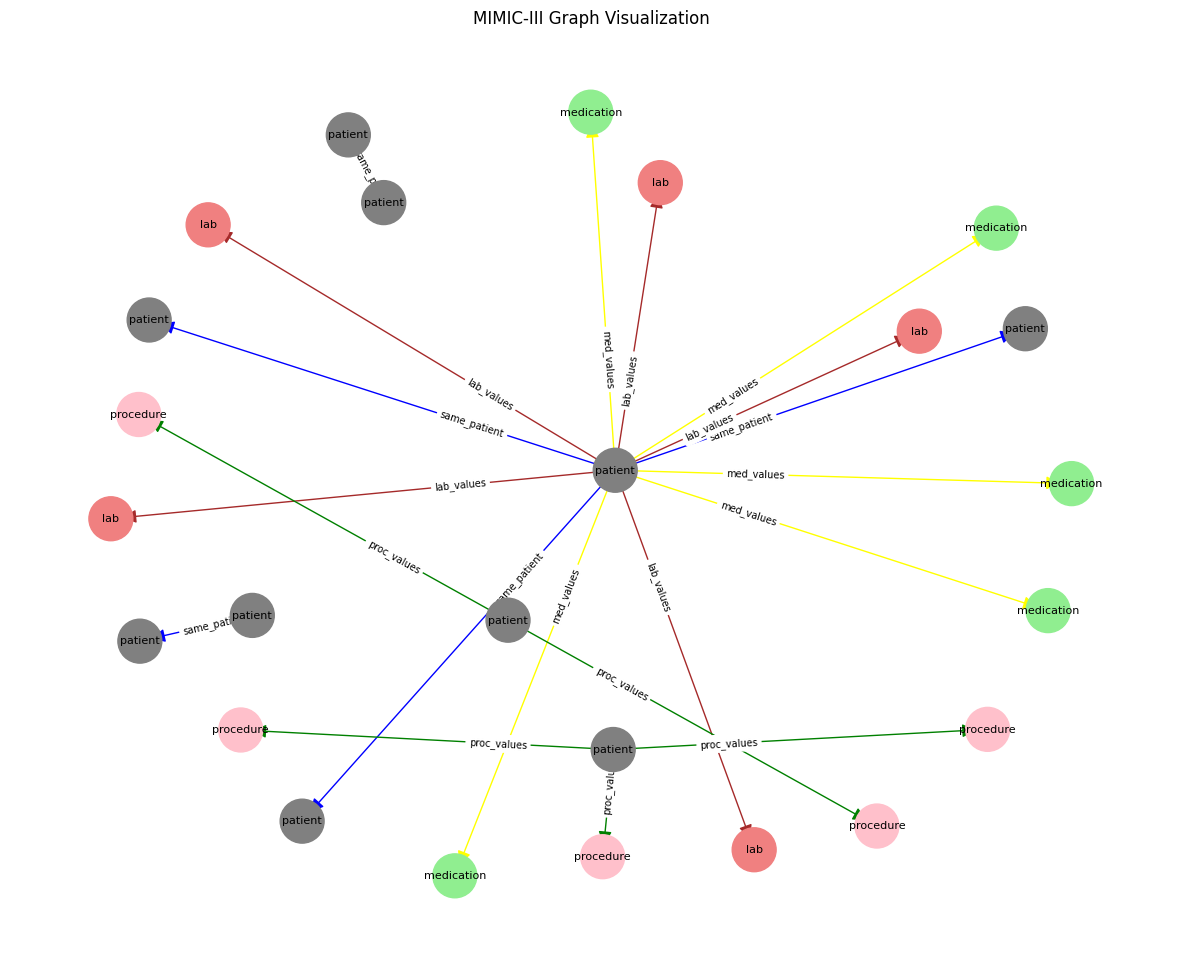

In [30]:
# A heterodata object to store the subset of the graph
visual_data = HeteroData()

# Create a sample of the graph
NUM_OF_EDGES_FOR_EACH_EDGETYPE = 5
source_indices = patient_edges[0][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
target_indices = patient_edges[1][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
visual_data['patient', 'same_patient', 'patient'].edge_index = torch.stack([source_indices, target_indices], dim=0)
source_indices = procedure_edges[0][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
target_indices = procedure_edges[1][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
visual_data['patient', 'proc_values', 'procedure'].edge_index = torch.stack([source_indices, target_indices], dim=0)
source_indices = medication_edges[0][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
target_indices = medication_edges[1][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
visual_data['patient', 'med_values', 'medication'].edge_index = torch.stack([source_indices, target_indices], dim=0)
source_indices = lab_edges[0][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
target_indices = lab_edges[1][:NUM_OF_EDGES_FOR_EACH_EDGETYPE]
visual_data['patient', 'lab_values', 'lab'].edge_index = torch.stack([source_indices, target_indices], dim=0)

# Create a networkX graph object
G = nx.DiGraph()
node_colors = {}
node_shapes = {}
edge_colors = {}

# Add nodes and edges
for edge_type in visual_data.edge_types:
    src_type, rel_type, dst_type = edge_type
    edge_index = visual_data[edge_type].edge_index
    for i in range(edge_index.size(1)):
        src_node_idx = edge_index[0, i].item()
        dst_node_idx = edge_index[1, i].item()
        src_node_id = f"{src_type}_{src_node_idx}"
        dst_node_id = f"{dst_type}_{dst_node_idx}"
        G.add_edge(src_node_id, dst_node_id, type=rel_type)
        if rel_type == 'same_patient':
            edge_colors[(src_node_id, dst_node_id)] = 'blue'
        elif rel_type == 'proc_values':
            edge_colors[(src_node_id, dst_node_id)] = 'green'
        elif rel_type == 'med_values':
            edge_colors[(src_node_id, dst_node_id)] = 'yellow'
        elif rel_type == 'lab_values':
            edge_colors[(src_node_id, dst_node_id)] = 'brown'
# for node in G.nodes():
#     print(node)
# for edge in G.edges():
#     print(edge)
    
# Specify the node colors
for node in G.nodes():
    if 'patient' in node:
        node_colors[node] = 'grey'
        node_shapes[node] = 'o' # Circle
    elif 'procedure' in node:
        node_colors[node] = 'pink'
        node_shapes[node] = 's' # Square
    elif 'medication' in node:
        node_colors[node] = 'lightgreen'
        node_shapes[node] = 't' # Triangle
    elif 'lab' in node:
        node_colors[node] = 'lightcoral'
        node_shapes[node] = 'a' # Star

# Visualize with Matplotlib
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42) # Choose a layout algorithm

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                       node_color=[node_colors[node] for node in G.nodes()],
                       node_shape='o', 
                       cmap=plt.cm.get_cmap('Pastel1'), 
                       node_size=1000) # Use a single shape for simplicity here, or iterate for different shapes

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color=[edge_colors.get((u, v), 'gray') for u, v in G.edges()], arrowsize=20)

# Draw labels
node_labels = {node: node.split('_')[0] for node in G.nodes()} # Show only node type
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
edge_labels = {(u, v): G[u][v]['type'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

# data = T.ToUndirected()(data)
# # data = T.AddSelfLoops()(data)
# # data = T.NormalizeFeatures()(data)
# data = data.to(device)

plt.title("MIMIC-III Graph Visualization")
plt.axis('off')
plt.savefig('mimic_graph_data_visualisation.png')

### Create a GAT model

In [ ]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, num_pat, num_proc, num_med, num_lab):
        super().__init__()
        self.lin_dict = torch.nn.ModuleDict()
#         for node_type in data.node_types:
#             self.lin_dict[node_type] = Linear(-1, hidden_channels)
        self.lin_dict["patient"] = Linear(num_pat, hidden_channels)
        self.lin_dict["procedure"] = Linear(num_proc, hidden_channels)
        self.lin_dict["medication"] = Linear(num_med, hidden_channels)
        self.lin_dict["lab"] = Linear(num_lab, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            # conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
            #                num_heads, group='sum')
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(), num_heads)
            self.convs.append(conv)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        out = self.lin(x_dict['patient'])
        out = F.sigmoid(out)
        return out

model = HGT(hidden_channels=64, out_channels=1, num_heads=2, num_layers=2, 
            num_pat=3, num_proc=len(procedure_features), num_med=len(medication_features), 
            num_lab=len(lab_features)).to(device)
print(model)

HGT(
  (lin_dict): ModuleDict(
    (patient): Linear(3, 64, bias=True)
    (procedure): Linear(93, 64, bias=True)
    (medication): Linear(277, 64, bias=True)
    (lab): Linear(1051, 64, bias=True)
  )
  (convs): ModuleList(
    (0-1): 2 x HGTConv(-1, 64, heads=2)
  )
  (lin): Linear(64, 1, bias=True)
)


### Train the GAT model

In [ ]:
losses = []
auprc_val = []
auprc_test = []
auprc_train = []
acc_val = []
acc_test = []
acc_train = []

with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['patient'].train_mask
#     print(out[mask].squeeze()[:2], data['patient'].y[mask][:2])
    for index, value in enumerate(data['patient'].y[mask].long()):
        if value not in [0, 1]:
            print(index, value)
    criterion = torch.nn.BCELoss()
    loss = criterion(out[mask].squeeze(), data['patient'].y[mask])
    loss.backward()
    optimizer.step()
    train_acc = ((out[mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[mask].detach().cpu().numpy()).sum()/len(out[mask])
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[mask].cpu().numpy(), out[mask].squeeze().detach().cpu().numpy())
    train_auprc = auc(recall, precision)
    return train_acc, train_auprc, float(loss)

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    val_mask = data['patient'].val_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[val_mask].cpu().numpy(), out[val_mask].squeeze().detach().cpu().numpy())
    val_auprc = auc(recall, precision)
    test_mask = data['patient'].test_mask
    precision, recall, thresholds = precision_recall_curve(data["patient"].y[test_mask].cpu().numpy(), out[test_mask].squeeze().detach().cpu().numpy())
    test_auprc = auc(recall, precision)
    val_acc = ((out[val_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[val_mask].detach().cpu().numpy()).sum()/len(out[val_mask])
    test_acc = ((out[test_mask].detach().cpu().numpy().squeeze()>0.5).astype(int) == data['patient'].y[test_mask].detach().cpu().numpy()).sum()/len(out[test_mask])
    return (val_auprc, test_auprc, val_acc, test_acc)

for epoch in range(1, config["epochs"]):
    train_acc, train_auprc, loss = train()
    val_auprc, test_auprc, val_acc, test_acc = test()
    losses.append(loss)
    auprc_train.append(train_auprc)
    acc_train.append(train_acc)
    auprc_val.append(val_auprc)
    acc_val.append(val_acc)
    auprc_test.append(test_auprc)
    acc_test.append(test_acc)
    print(f'{epoch:03d}, Loss: {loss:.3f}, TrPRC: {train_auprc:.3f}, TrAcc: {train_acc:.3f}, VaPRC: {val_auprc:.3f}, VaAcc: {val_acc:.3f}, TePRC: {test_auprc:.3f}, TeAcc: {test_acc:.3f}')

/tmp/ipykernel_2447878/3335577706.py:31: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return train_acc, train_auprc, float(loss)


001, Loss: 0.782, TrPRC: 0.507, TrAcc: 0.384, VaPRC: 0.527, VaAcc: 0.568, TePRC: 0.555, TeAcc: 0.577
002, Loss: 0.696, TrPRC: 0.553, TrAcc: 0.551, VaPRC: 0.650, VaAcc: 0.622, TePRC: 0.624, TeAcc: 0.617
003, Loss: 0.724, TrPRC: 0.679, TrAcc: 0.605, VaPRC: 0.661, VaAcc: 0.608, TePRC: 0.629, TeAcc: 0.617
004, Loss: 0.684, TrPRC: 0.683, TrAcc: 0.599, VaPRC: 0.702, VaAcc: 0.601, TePRC: 0.641, TeAcc: 0.611


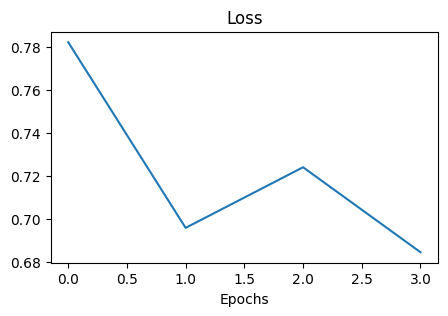

In [25]:
plt.figure(figsize=(5,3))
plt.title("Loss")
plt.xlabel("Epochs")
plt.plot(losses)
plt.show()

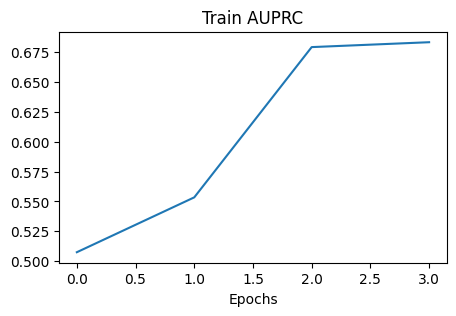

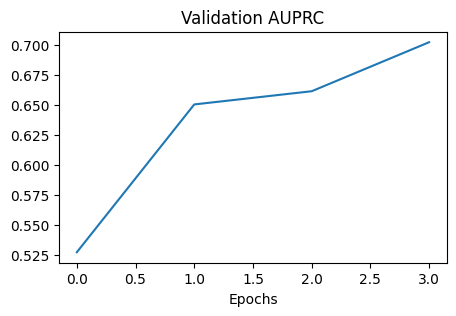

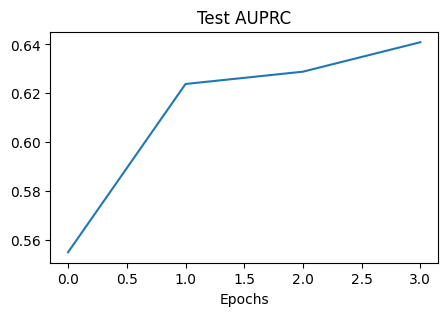

In [26]:
plt.figure(figsize=(5,3))
plt.title("Train AUPRC")
plt.plot(auprc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_val)
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test AUPRC")
plt.xlabel("Epochs")
plt.plot(auprc_test)
plt.show()

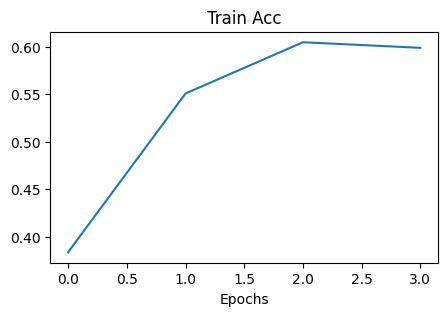

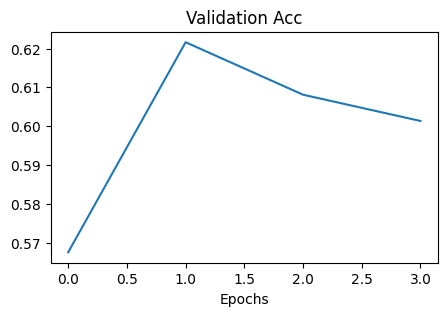

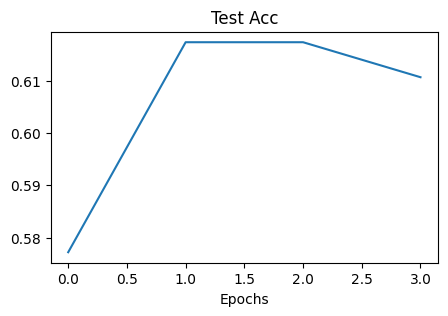

In [27]:
plt.figure(figsize=(5,3))
plt.title("Train Acc")
plt.plot(acc_train)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Validation Acc")
plt.plot(acc_val)
plt.xlabel("Epochs")
plt.show()

plt.figure(figsize=(5,3))
plt.title("Test Acc")
plt.plot(acc_test)
plt.xlabel("Epochs")
plt.show()